# Homework 1

## Problem 4

In [1]:
import pandas as pd

# Task: import the csv file
folder = r'C:\Users\prife\OneDrive - KTH\KTH\01 Courses\Data-driven Methods\HW1' + "\\"
HW1Q4 = pd.read_csv(folder + "HW1Q4.csv",header = None)

### Task: compute the economy SVD and plot the singular values and the first 3 left and right singular vectors

In [2]:
import numpy as np

Uhat, Shat, VThat = np.linalg.svd(HW1Q4,full_matrices=False)

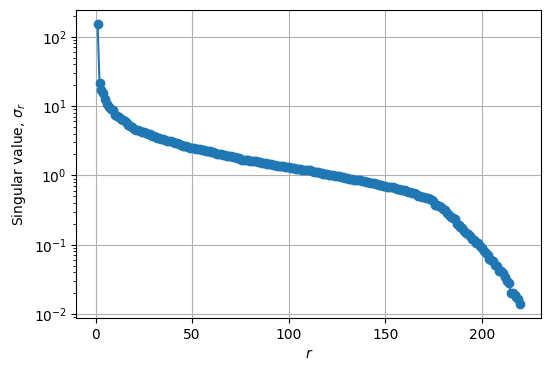

In [3]:
import matplotlib.pyplot as plt

# Singular values plot
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(1, Shat.size+1), Shat, marker='o')
plt.xlabel(r"$r$")
plt.ylabel(r"Singular value, $\sigma_{r}$")
plt.grid(True)
plt.show()

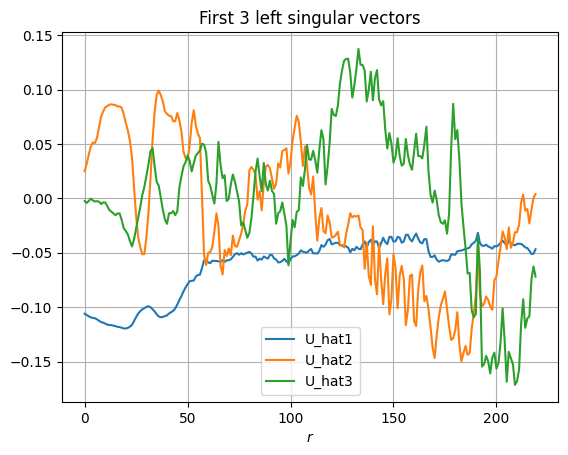

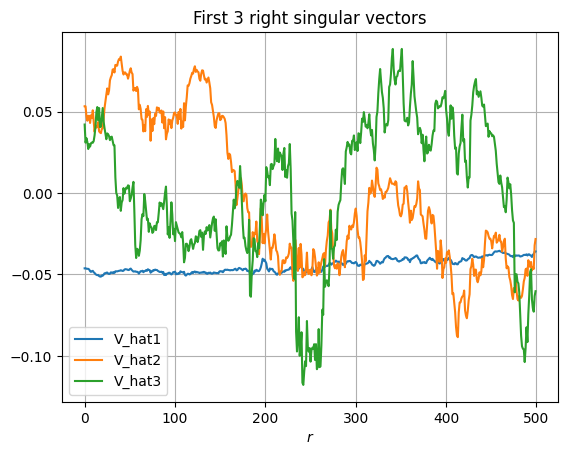

In [4]:
# First 3 columns of U
plt.plot(Uhat[:, :3])
plt.title("First 3 left singular vectors")
plt.xlabel(r"$r$")
plt.legend([f"U_hat{i+1}" for i in range(3)])
plt.grid(True)
plt.show()

# First 3 columns of V
Vhat = VThat.T
plt.plot(Vhat[:, :3])
plt.title("First 3 right singular vectors")
plt.xlabel(r"$r$")
plt.legend([f"V_hat{i+1}" for i in range(3)])
plt.grid(True)
plt.show()

### Task: Verify that the square of the Frobenius norm of the data projected onto the first three singular vectors is equal to the sum of the squares of the first three singular values.

In [5]:
# Calculate the third rank approximation
HW1Q4_3 = Uhat[:, :3] @ np.diag(Shat[:3]) @ VThat[:3,:]

fro2 = np.linalg.norm(HW1Q4_3, 'fro')**2
sum_Shat_sq = np.sum(Shat[:3]**2)

print(f"Frobenius norm squared = {fro2}")
print(f"Sum of the squares of first 3 singular values = {sum_Shat_sq}")
print(f"Difference = {fro2 - sum_Shat_sq}")


Frobenius norm squared = 24476.487023576123
Sum of the squares of first 3 singular values = 24476.487023576123
Difference = 0.0


## Problem 5

Fraudulent coin indices: [17 54 70 98]


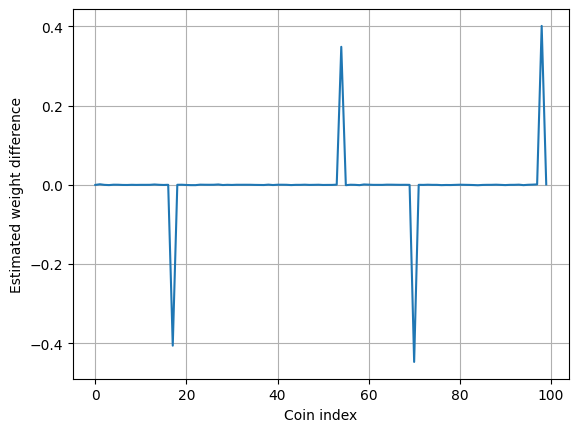

In [67]:
from scipy.optimize import minimize

# Solving Cx = b for "x"
C = np.loadtxt(folder + "hw1Q5C.dat",delimiter=",")  # 20x100,
b = np.loadtxt(folder + "hw1Q5b.dat",delimiter=",")

# L1 Minimum norm solution x_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'eq', 'fun': lambda x: C @ x - b})
x0 = np.linalg.pinv(C) @ b # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
x_L1 = res.x

fraudulent_coin_indices = np.where(np.abs(x_L1) > 0.01)[0]
print("Fraudulent coin indices:", fraudulent_coin_indices)

plt.plot(np.arange(100), x_L1)
plt.xlabel('Coin index')
plt.ylabel('Estimated weight difference')
plt.grid(True)
plt.show()

## Problem 6

In [68]:
from nbclient import NotebookClient
import nbformat

# Load w1Q6.ipynb, run, and get matrix X
nb = nbformat.read(folder + "hw1Q6.ipynb", as_version=4)

namespace = {}
for cell in nb.cells:
    if cell.cell_type == "code":
        exec(cell.source, namespace)

X = namespace['X']
y = namespace['y']

### Compute the SVD and plot the first 2 left singular vectors against the spatial coordinate 'y'

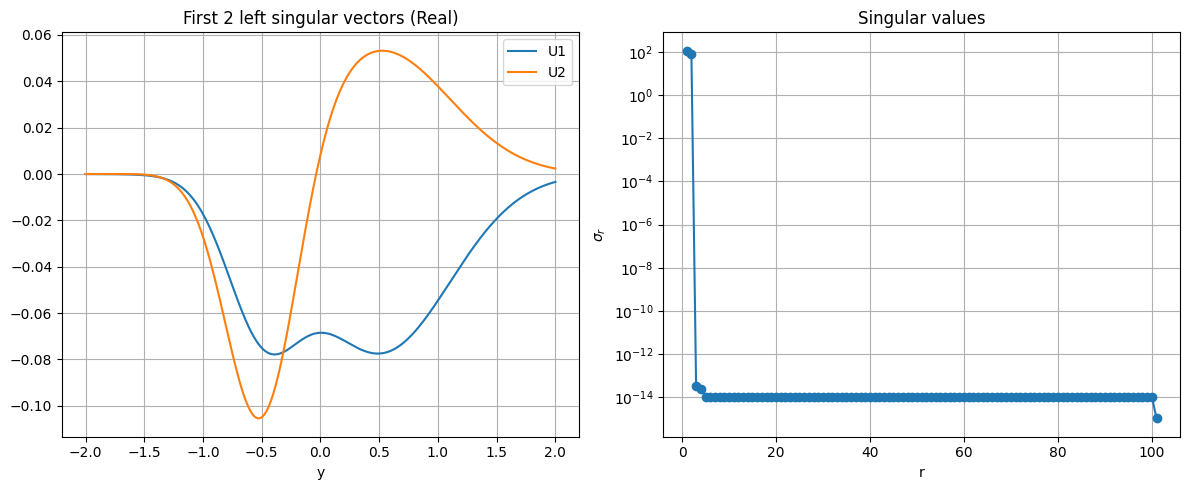

In [69]:
U, S, VT = np.linalg.svd(X,full_matrices=True)

# First 2 columns of complex U
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Real part
axes[0].plot(y, U[:, :2].real)
axes[0].set_title("First 2 left singular vectors (Real)")
axes[0].set_xlabel("y")
axes[0].legend([f"U{i+1}" for i in range(2)])
axes[0].grid(True)

# 2. Singular values
axes[1].semilogy(np.arange(1, S.size+1), S, marker='o')
axes[1].set_title("Singular values")
axes[1].set_xlabel("r")
axes[1].set_ylabel(r"$\sigma_r$")
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Compute the DMD (matrix A such that X'=AX) of X. Plot the eigenvectors of A that correspond to non-zero eigenvalues

In [71]:
# DMD implementation

def DMD(X,Xprime,r):
    # Step 1: Compute the SVD of X
    U,Sigma,VT = np.linalg.svd(X, full_matrices=0)
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]

    # Step 2: Get A tilde by computing the pseudo-inverse of X
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T  # eq (7.20)

    # Step 3: Spectral decomposition of A tilde
    Lambda, W = np.linalg.eig(Atilde)
    Lambda = np.diag(Lambda)

    # Step 4: Reconstruct high dimansional DMD modes (Phi) using eigenvectors W of the reduced system and the time-shifted snapshot matrix X′
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W  # eq (7.23)

    # DMD Expansion
    alpha1 = Sigmar @ VTr[:,0]  # first snapshot in the reduced basis (initial condition)
    b = np.linalg.solve(W @ Lambda,alpha1)  # eq (7.32f)
    return Phi, Lambda, b

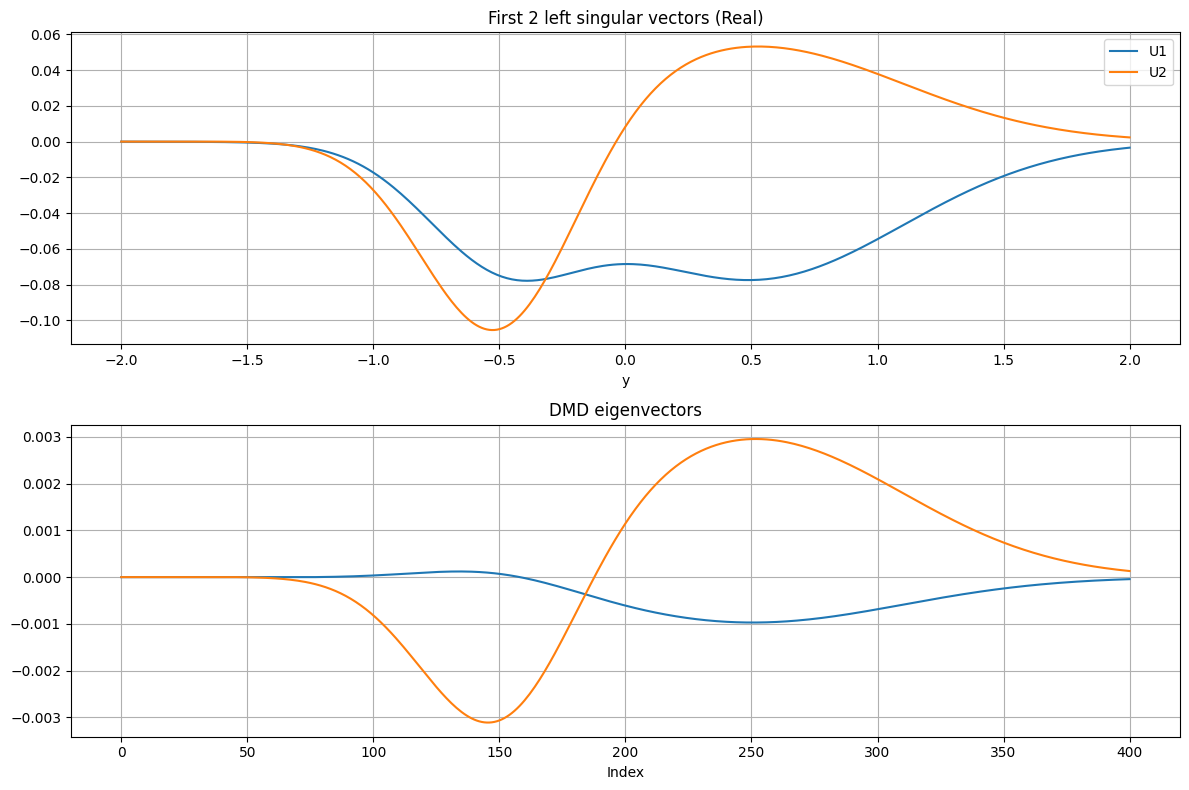

In [73]:
rank = 2
Phi, Lambda, b = DMD(X[:,:-1],X[:,1:],rank)

# Plot each eigenvector
Lambda = np.diag(Lambda)
nonzero_eigs = np.where(np.abs(Lambda) > 0)[0]
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# 1. Real part
axes[0].plot(y, U[:, :2].real)
axes[0].set_title("First 2 left singular vectors (Real)")
axes[0].set_xlabel("y")
axes[0].legend([f"U{i+1}" for i in range(2)])
axes[0].grid(True)

# 2. Singular values
for i in nonzero_eigs:
    axes[1].plot(Phi[:, i].real, label=f"Phi{i+1}")
axes[1].set_title("DMD eigenvectors")
axes[1].set_xlabel("Index")
# axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### How do the non-zero Lambdas relate to the parameters used to define X?

In [78]:
dt = y = namespace['dt']
print(Lambda)
Lambda_c = np.log(Lambda) / dt
print(Lambda_c)

[0.00802064+0.0387574j  0.02569358-0.02510475j]
[-32.29466228+13.66732064j -33.26398296 -7.73807175j]
